# Explaining Text Classifiers with Counterfactual Representations 

Dataset: EEEC+ with 'gender' as the manipulated concept (2 concept values)

Balanced training scenario

In [1]:
from concept_erasure import LeaceEraser, LeaceFitter
import torch
import numpy as np
import scipy

from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.neural_network import MLPClassifier,  MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter


In [2]:
# Global parameters

projection_method = 'orth' # 'orth' or 'leace' ('leace' is the oblique projection from Belrose et al., 2023, LEACE: Perfect linear concept erasure in closed form, NeurIPS 2023)
global_seed = 42 # used for reproductibility
rcond = 1e-5 # used for regressions 

dataset = 'EEEC_plus'
dataset = 'balanced' # 'balanced' or 'aggressive'

lin_cl_loss = 'log_loss'
concept_manipulated = 'gender' # 'gender' or 'race'

## LOADING DATA 

- Data is located in the dataset: *./datasets/EEEC/EEEC_3race/*
- **bert** representations for each observations have been pre-calculated using **bert-base-uncased** model (via Huggingface library) and stored in a dictonnary of arrays *D.npz*

## Loading train, validation and test data

In [3]:
base_dir = './datasets/EEEC/EEEC_3race/'


# Load a train and validation set corresponding to the training scenario (aggressive or balanced)
# Load the test set of the balanced version of EEEC+
if dataset == 'balanced':
    with np.load(base_dir + 'D_balanced.npz') as balanced_data:
        X, Z_raw, Y_raw = balanced_data['train_X'], balanced_data[f'train_Z_{concept_manipulated}'], balanced_data['train_Y']
        X_test, Z_test_raw, Y_test_raw = balanced_data['test_X'], balanced_data[f'test_Z_{concept_manipulated}'], balanced_data['test_Y']
        
        X_val, Z_val_raw, Y_val_raw =  balanced_data['validation_X'], balanced_data[f'validation_Z_{concept_manipulated}'], balanced_data['validation_Y']
else:
    with np.load(base_dir + f'D_aggressive_{concept_manipulated}.npz') as aggressive_data:
        X, Z_raw, Y_raw = aggressive_data['train_X'], aggressive_data[f'train_Z_{concept_manipulated}'], aggressive_data['train_Y']
        # X_test, Z_test_raw, Y_test_raw = balanced_data['test_X'], balanced_data['test_Z_race'], balanced_data['test_Y']
        X_val, Z_val_raw, Y_val_raw =  aggressive_data['validation_X'], aggressive_data[f'validation_Z_{concept_manipulated}'], aggressive_data['validation_Y']
    with np.load(base_dir + f'D_balanced.npz') as balanced_data:
        # X, Z_raw, Y_raw = balanced_data['train_X'], balanced_data['train_Z_race'], balanced_data['train_Y']
        X_test, Z_test_raw, Y_test_raw = balanced_data['test_X'], balanced_data[f'test_Z_{concept_manipulated}'], balanced_data['test_Y']


n, d = X.shape # n: number of observations in the train set, d: number of features
n_test, _ = X_test.shape # n_test: number of observations in the test set
n_validation, _ = X_val.shape # n_validation: number of observations in the validation set
z_values = sorted(np.unique(Z_raw)) # list of concept values
k = len(z_values) # number of concept values
y_values = sorted(np.unique(Y_raw)) # list of labels for the downstream task
m = len(y_values) # number of labels for the downstream task

z_label2id = {z_values[i]:i for i in range(len(z_values))}
y_label2id = {y_values[i]:i for i in range(len(y_values))}

Z = np.array([z_label2id[z] for z in Z_raw]).astype(int)
Z_test = np.array([z_label2id[z] for z in Z_test_raw]).astype(int)
Z_val = np.array([z_label2id[z] for z in Z_val_raw]).astype(int)
Y = np.array([y_label2id[y] for y in Y_raw]).astype(int)
Y_test = np.array([y_label2id[y] for y in Y_test_raw]).astype(int)
Y_val =  np.array([y_label2id[y] for y in Y_val_raw]).astype(int)


# Calculate the one hot version of Z
def to_one_hot(A):
        A_1hot = np.zeros((A.size, A.max()+1))
        A_1hot[np.arange(A.size), A] = 1
        return A_1hot
Z_1hot = to_one_hot(Z)

# calculate number of observations per value of Z and Y
z_label2numobs_train = {z_values[i]:np.nonzero([Z==z_label2id[z_values[i]]])[0].shape[0] for i in range(len(z_values))}
z_label2numobs_validation = {z_values[i]:np.nonzero([Z_val==z_label2id[z_values[i]]])[0].shape[0] for i in range(len(z_values))}
z_label2numobs_test = {z_values[i]:np.nonzero([Z_test==z_label2id[z_values[i]]])[0].shape[0] for i in range(len(z_values))}
y_label2numobs_train = {y_values[i]:np.nonzero([Y==y_label2id[y_values[i]]])[0].shape[0] for i in range(len(y_values))}
y_label2numobs_validation = {y_values[i]:np.nonzero([Y_val==y_label2id[y_values[i]]])[0].shape[0] for i in range(len(y_values))}
y_label2numobs_test = {y_values[i]:np.nonzero([Y_test==y_label2id[y_values[i]]])[0].shape[0] for i in range(len(y_values))}

# Display dataset statistics:
print(f''' 
Features:
    d = {d}
Number of observations:
    train: {n}
    validation: {n_validation}
    test: {n_test}
Z labels (protected concept levels): 
    k = {k} 
    mapping: {z_label2id.__str__()}
    num_obs_train: {z_label2numobs_train.__str__()}
    num_obs_validation: {z_label2numobs_validation.__str__()}
    num_obs_test: {z_label2numobs_test.__str__()}
Y labels (downstream task): 
    m = {m}
    mapping: {y_label2id.__str__()}
    num_obs_train: {y_label2numobs_train.__str__()}
    num_obs_validation: {y_label2numobs_validation.__str__()}
    num_obs_test: {y_label2numobs_test.__str__()}
''')

 
Features:
    d = 768
Number of observations:
    train: 25600
    validation: 6400
    test: 8000
Z labels (protected concept levels): 
    k = 2 
    mapping: {'female': 0, 'male': 1}
    num_obs_train: {'female': 12872, 'male': 12728}
    num_obs_validation: {'female': 3240, 'male': 3160}
    num_obs_test: {'female': 4019, 'male': 3981}
Y labels (downstream task): 
    m = 5
    mapping: {'anger': 0, 'fear': 1, 'joy': 2, 'neutral': 3, 'sadness': 4}
    num_obs_train: {'anger': 5072, 'fear': 5122, 'joy': 5182, 'neutral': 5117, 'sadness': 5107}
    num_obs_validation: {'anger': 1256, 'fear': 1303, 'joy': 1257, 'neutral': 1247, 'sadness': 1337}
    num_obs_test: {'anger': 1635, 'fear': 1530, 'joy': 1587, 'neutral': 1639, 'sadness': 1609}



In [4]:
# Displaying correlations in the train set
y_id2label = {int(v):k for k,v in y_label2id.items()}
z_id2label = {int(v):k for k,v in z_label2id.items()}
for i in np.unique(Y):
    for j in np.unique(Z):
        print(f"p(y={y_id2label[i]}|z={z_id2label[j]})={sum(Z[Y==i]==j)/sum(Y==i):.2f}")
    print(' ')

p(y=anger|z=female)=0.50
p(y=anger|z=male)=0.50
 
p(y=fear|z=female)=0.52
p(y=fear|z=male)=0.48
 
p(y=joy|z=female)=0.50
p(y=joy|z=male)=0.50
 
p(y=neutral|z=female)=0.50
p(y=neutral|z=male)=0.50
 
p(y=sadness|z=female)=0.50
p(y=sadness|z=male)=0.50
 


## Loading balanced counterfactuals of test data

In [5]:
with np.load(base_dir + f'D_CF_{concept_manipulated}.npz') as CF_data:
    X_CF_test, Z_CF_test_raw, Y_CF_test_raw = CF_data['test_X'], CF_data[f'test_Z_{concept_manipulated}'], CF_data['test_Y']
Z_CF_test = np.array([z_label2id[z] for z in Z_CF_test_raw]).astype(int)

# Training linear classifiers

$\hat{Y}$: mood state classifier (POMS)

$\hat{Z}$: race classifier (3 values)

Training a POMS linear classifier

In [6]:
def linear_classifier(args, random_state=global_seed):
    lcf = SGDClassifier(
        loss=lin_cl_loss, validation_fraction=0.2, early_stopping=True, random_state=random_state, 
        penalty='l2', max_iter=5000, n_jobs=-1, learning_rate='optimal', warm_start=True, n_iter_no_change=200
    )
    lcf.set_params(**args)
    return lcf

### Training of $\widehat{Y}$

In [7]:
## Uncomment if you want to make a grid search
#
# eta_y = linear_classifier({'alpha': 1e-4})
## parameters = {
#     'alpha':[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
# }
# eta_y = GridSearchCV(eta_y, parameters)

In [8]:
eta_y = linear_classifier({'alpha': 1e-4})
eta_y.fit(X, Y)
print("Train accuracy:", f"{100*eta_y.score(X, Y):.2f}%")
print("Test accuracy: ", f"{100*eta_y.score(X_test, Y_test):.2f}%") # reminder: train is aggressive, test is balanced

Train accuracy: 79.29%
Test accuracy:  77.05%


In [9]:
print("Per value accuracy:\n")
y_predicted = eta_y.predict(X)
y_predicted_test = eta_y.predict(X_test)
print("label id", "label name", "train acc. (%)", "test acc. (%)")
for i in range(m):
    acc_i = np.sum(y_predicted[Y == i] == i) / np.sum([Y == i])
    acc_i_test = np.sum(y_predicted_test[Y_test == i] == i) / np.sum([Y_test == i])
    print(f"{i:<8}",f"{y_id2label[i]:<10}", f"{100*acc_i:<14.2f}", f"{100*acc_i_test:<13.2f}")


Per value accuracy:

label id label name train acc. (%) test acc. (%)
0        anger      83.28          78.47        
1        fear       64.08          65.69        
2        joy        89.14          87.90        
3        neutral    72.50          68.46        
4        sadness    87.39          84.46        


### Training of $\widehat{Z}$

In [10]:
## Uncomment if you want to make a grid search
#
# eta_z = linear_classifier({'alpha': 1e-5})
# parameters = {
#     'alpha':[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
# }
# eta_z = GridSearchCV(eta_y, parameters)

In [11]:
eta_z = linear_classifier({'alpha': 1e-5})
eta_z.fit(X, Z)
print("Train accuracy:", f"{100*eta_z.score(X, Z):.2f}%")
print("Test accuracy: ", f"{100*eta_z.score(X_test, Z_test):.2f}%") 

Train accuracy: 99.66%
Test accuracy:  99.05%


In [12]:
print("Per value accuracy:\n")
z_predicted = eta_z.predict(X)
z_predicted_test = eta_z.predict(X_test)
print("label id", f"{'label name':<25}", "train acc. (%)", "test acc. (%)")
for i in range(k):
    acc_i = np.sum(z_predicted[Z == i] == i) / np.sum([Z == i])
    acc_i_test = np.sum(z_predicted_test[Z_test == i] == i) / np.sum([Z_test == i])
    print(f"{i:<8}",f"{z_id2label[i]:<25}", f"{100*acc_i:<14.2f}", f"{100*acc_i_test:<13.2f}")

Per value accuracy:

label id label name                train acc. (%) test acc. (%)
0        female                    99.33          98.36        
1        male                      99.99          99.75        


### Training a non-linear classifier (2-layer MLP) on X

In [13]:
mlpclf_y = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=global_seed, max_iter=300, early_stopping=True).fit(X, Y)
print("Train accuracy:", f"{100*mlpclf_y.score(X, Y):.2f}%")
print("Test accuracy: ", f"{100*mlpclf_y.score(X_test, Y_test):.2f}%") # reminder: train is aggressive, test is balanced

Train accuracy: 95.12%
Test accuracy:  82.14%


## Concept Erasure

Concept to erase: gender (2 values)\
Erasure method: orthogonal projection on $V^\perp$ (by default) or LEACE oblique projection on $V^\perp$ 

### Erasure

In [14]:
class Erasure:
    
    def __init__(self, projection='orth', rcond=1e-5):
        """
        Parameters: 
        projection (str): 'orth' for an orthogonal projection, 'leace' for an oblique projection using the LEACE projector
        rcond (str): linalg rcond coef
        """
        self.rcond = rcond
        self.projection = projection
        self.P = None
        self.SigXZ = None
        self.E_SigXZ = None
        self.E_P = None
    
    def fit(self, X, Z_1hot):
        self.SigXZ = LeaceFitter.fit(
            torch.Tensor(X),
            torch.Tensor(Z_1hot)
        ).sigma_xz.numpy()
        self.E_SigXZ = scipy.linalg.orth(self.SigXZ, rcond=self.rcond).T

        if self.projection == 'leace':
            self.P = LeaceEraser.fit(
                torch.Tensor(X),
                torch.Tensor(Z_1hot)                    
        ).P.numpy()
        else:
            # I - A (A.T A)^-1 A.T
            self.P = np.eye(self.SigXZ.shape[0]) - self.E_SigXZ.T @ np.linalg.inv(self.E_SigXZ @ self.E_SigXZ.T) @ self.E_SigXZ
        self.E_P = scipy.linalg.orth(self.P, rcond=self.rcond).T
    
    def erase_concept(self, X):
        return X @ self.P.T
    
    def to_vec(self, coordinates, subspace):
        E_subspace = self.E_P if subspace == 'E_P' else self.E_SigXZ
        if len(coordinates.shape) < 2:
            return coordinates[:,np.newaxis] @ E_subspace
        else:
            return coordinates @ E_subspace
    
    def get_coordinates(self, X, subspace):
        E_subspace = self.E_P if subspace == 'E_P' else self.E_SigXZ
        if self.projection == 'leace':
            return (X - X @ self.P.T) @ E_subspace.T.squeeze()
        else:
            return X @ E_subspace.T.squeeze()


In [15]:
LinearErasure = Erasure(projection=projection_method, rcond=rcond)
LinearErasure.fit(X, Z_1hot)
print("Rank of colsp(Sigma_XZ):", LinearErasure.E_SigXZ.shape[0], f"\t(sanity check: must be equal to k-1 = {k-1})")
print("Rank of colsp(P):       ", LinearErasure.E_P.shape[0], f"\t(sanity check: must be equal to d-k+1 = {d-k+1})")

Rank of colsp(Sigma_XZ): 1 	(sanity check: must be equal to k-1 = 1)
Rank of colsp(P):        767 	(sanity check: must be equal to d-k+1 = 767)


### Evaluation of the linear erasure

In [16]:
X_ = LinearErasure.erase_concept(X)
X_test_ = LinearErasure.erase_concept(X_test)

# Check that predicting linearly Z from X_ leads to bad results (concept has been erased linearly)
sgdclass = linear_classifier({'alpha': 1e-4}).fit(X_, Z)
print(f"Accuracy of a linear classifier trained to predict Z from X_orth:")
print("Train accuracy:", f"{100*sgdclass.score(X_,Z):.2f}%")
print("Test accuracy: ", f"{100*sgdclass.score(X_test_, Z_test):.2f}%", f"\t(must be approx. {100/k:.2f}%)\n") 


Accuracy of a linear classifier trained to predict Z from X_orth:
Train accuracy: 50.32%
Test accuracy:  50.25% 	(must be approx. 50.00%)



In [17]:
# Check if a non-linear classifier can predict accurately Z from X_
mlpclf = MLPClassifier(random_state=global_seed, max_iter=300, early_stopping=True).fit(X_, Z)
print(f"Accuracy of a non-linear classifier (2-layer MLP) trained to predict Z from X_orth:")
print("Train accuracy:", f"{100*mlpclf.score(X_,Z):.2f}%")
print("Test accuracy: ", f"{100*mlpclf.score(X_test_, Z_test):.2f}%", f"\t(>> {100/k:.2f}%))")

Accuracy of a non-linear classifier (2-layer MLP) trained to predict Z from X_orth:
Train accuracy: 99.93%
Test accuracy:  98.89% 	(>> 50.00%))


# Plot the data

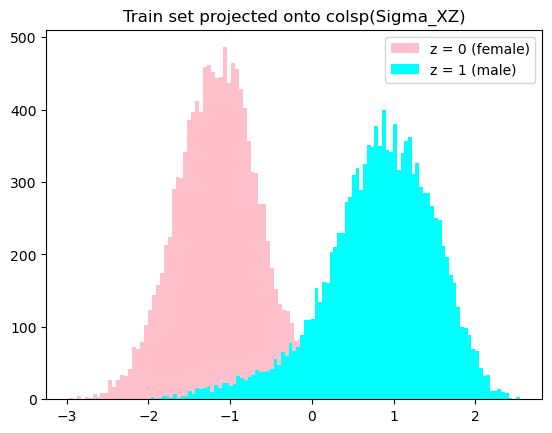

In [18]:
# Plot

# need to add the case where v[0] == 0
def vect_to_equation(v, x, intercept_x = 0):
    y = v[1] / v[0] * (x - intercept_x) 
    return y

lambda_SigXZ = LinearErasure.get_coordinates(X, subspace='E_SigXZ')
mean_lambda = np.mean(lambda_SigXZ)

colors = ['pink', 'cyan']

# Plot the training data points 
for z in np.unique(Z):
    indices = Z == z
    X_SigXZ_z = lambda_SigXZ[indices]
    _ = pyplot.hist(X_SigXZ_z, bins=100, label=f'z = {z} ({z_id2label[z]})', color=colors[z])

_ = pyplot.title('Train set projected onto colsp(Sigma_XZ)')
_ = pyplot.legend()


# Linear reconstruction of $x^\parallel$ with a MSE loss objective

In [19]:
# To improve
# - don't use LEACE library to calculate Sigma_XZ and the LEACE projector

class LinearConceptValueAssignmentWithMSEloss:

    def __init__(self, random_state=global_seed, rcond=rcond):
        self.predictors = {}
        self.noises = {}
        self.LinearErasure = Erasure() # P and Sigma_XZ in it
        self.random_state = random_state
        self.alpha = 5e-2 #orth
        # self.alpha = 1e-4 #leace
        self.lr = 1e-3

    def fit_linear_regression(self, X, Z, linreg_args = {}, validate=False, X_validation=None, Z_validation=None):
        shuffle = True
        validation_fraction = 0.3
        if validate:
            validation_fraction = X_validation.shape[0] / (X.shape[0] + X_validation.shape[0]) 
            X = np.concatenate((X,X_validation), axis=0)
            Z = np.concatenate((Z,Z_validation))
            shuffle = False
        
        X_ = self.LinearErasure.erase_concept(X)
        coord_SigXZ = self.LinearErasure.get_coordinates(X, subspace='E_SigXZ')
        for z in np.unique(Z): 
            linear_regression_mse = MLPRegressor(
                hidden_layer_sizes=(), # linear
                activation="identity",
                max_iter=5000,
                solver='adam',
                early_stopping=True,
                validation_fraction=validation_fraction,
                n_iter_no_change=100,
                alpha=self.alpha,
                learning_rate_init=self.lr,
                random_state=self.random_state,
                warm_start=True,
                shuffle=shuffle
            )
            linear_regression_mse.set_params(**linreg_args)
            linear_regression_mse.fit(X_[Z==z], coord_SigXZ[Z==z])
            self.predictors[z] = linear_regression_mse
        return True

    def fit_gaussian_dispersion(self, X, Z):
        X_ = self.LinearErasure.erase_concept(X)
        coord_SigXZ = self.LinearErasure.get_coordinates(X, subspace='E_SigXZ')
        # Calculate the noise variance per concept value
        for z in np.unique(Z):
            nu_X = self.predictors[z].predict(X_[Z==z])
            noise = coord_SigXZ[Z==z] - nu_X
            if noise.ndim == 1:
                noise = noise.reshape(-1, 1)
            gmm = GaussianMixture(n_components=1, covariance_type='full', max_iter=300)
            gmm.fit(noise)
            self.noises[z] = gmm
        return True

    def fit(self, X, Z, validate=False, X_validation=None, Z_validation=None):
        self.fit_linear_regression(X, Z, validate=validate, X_validation=X_validation, Z_validation=Z_validation)
        self.fit_gaussian_dispersion(X, Z)
        return True
    
    def predict_nu(self, X, Z_assigned):
        X_ = self.LinearErasure.erase_concept(X)
        coord_SigXZ_predicted = np.empty((X.shape[0], self.LinearErasure.E_SigXZ.shape[0]))
        for z in np.unique(Z_assigned):
            indices = Z_assigned == z
            predictions = self.predictors[z].predict(X_[indices])
            if len(predictions.shape) < 2: # predictions must be a matrix with 2 dimensions
                predictions = predictions[:,np.newaxis]
            coord_SigXZ_predicted[indices] = predictions
        X_SigXZ  = self.LinearErasure.to_vec(coord_SigXZ_predicted, subspace='E_SigXZ') 
        return X_ + X_SigXZ


    def predict(self, X, Z_assigned, no_sampling = False):
        X_n_nu = self.predict_nu(X, Z_assigned)
        # Let's sample noise for each observation
        if not no_sampling:
            X_noises_sampled = np.empty(X.shape)
            for z in np.unique(Z_assigned):
                indices = Z_assigned == z
                n_noises = np.sum(indices)
                noises = self.noises[z].sample(n_noises)
                X_noises_sampled[indices] = self.LinearErasure.to_vec(noises[0],subspace='E_SigXZ')
            return X_n_nu + X_noises_sampled
        else:
            return X_n_nu
        
    def score(self, X, Z):
        X_nu = self.predict(X, Z, no_sampling=True) 
        return np.mean(np.linalg.norm(X-X_nu, axis=1))

    def sample_counterfactuals(self, X, z_value, no_sampling=False):
        color = 'blue'
        Z_assigned = np.full((X.shape[0],), z_value)
        X_to_plot = self.predict(X, Z_assigned, no_sampling)
        X_to_plot = self.LinearErasure.get_coordinates(X_to_plot, subspace='E_SigXZ')
        if len(X_to_plot.shape) > 1 and X_to_plot.shape[1] == 2:
            _ = pyplot.scatter(X_to_plot[:,0], X_to_plot[:,1], s=0.1, color=color)
        elif len(X_to_plot.shape) == 1:
            _ = pyplot.hist(X_to_plot[:,], bins=100, color=color)  
    


In [20]:
LCVA_mse = LinearConceptValueAssignmentWithMSEloss(random_state=global_seed)
LCVA_mse.LinearErasure = LinearErasure
LCVA_mse.fit(X,Z, validate=True, X_validation=X_val, Z_validation=Z_val)

True

In [21]:
print("MSE (train):     ", f"{LCVA_mse.score(X, Z):.4f}")
print("MSE (validation):", f"{LCVA_mse.score(X_val, Z_val):.4f}")
print("MSE (test):      ", f"{LCVA_mse.score(X_test, Z_test):.4f}")


MSE (train):      0.1658
MSE (validation): 0.1645
MSE (test):       0.1703


In [22]:
print("Test accuracy of \hatY (reminder):", f"{100*eta_y.score(X_test, Y_test):.2f}%")
print("Accuracy of \hatY on genuine CFs: ", f"{100*eta_y.score(X_CF_test, Y_test):.2f}%", "(must be approx. equal to the train accuracy)") # CFs are labelled with the same Y as original data

Test accuracy of \hatY (reminder): 77.05%
Accuracy of \hatY on genuine CFs:  76.98% (must be approx. equal to the train accuracy)


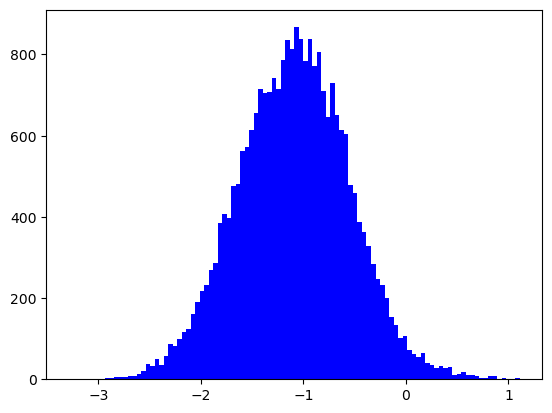

In [23]:
# Sample countefractuals and display them in V^{\parallel}
LCVA_mse.sample_counterfactuals(X, z_value=0, no_sampling=True)

## Evaluations

### $\mathrm{PIP}$ and $\mathrm{ATV}$



From the paper:

Let $\mathcal{S}:=\{(s_i,z_i)\}$ be a set of couples of text documents $s_i$ and of CF values $z_i\neq Z(s_i)$. Define the proportion of identical predictions ($\mathrm{PIP}$) by

$$\mathrm{PIP}_{\widehat{Y}}[\mathcal{S}]:=  \frac{1}{|\mathcal{S}|} \sum_{(s,z)\in\mathcal{S}} \mathbf{1}\left[\widehat{Y}(X(s_{Z\leftarrow z})) = \widehat{Y}(X(s)_{Z\leftarrow z})\right].$$

The range of the \noindent $\mathrm{PIP}$ metric is $[0,1]$, closer to $1$ being better. Similarly, we define $\mathrm{PIP}_{\widehat{Z}}[\mathcal{S}]$.

Let $p_{\widehat{Y}}(x)$ be the probability distribution over $Y$-values used by the classifier $\widehat{Y}$. Define the average total variation (ATV) distance by

$$\mathrm{ATV}_{\widehat{Y}}[\mathcal{S}]:= \frac{1}{|\mathcal{S}|} \sum_{(s,z)\in\mathcal{S}}\underbrace{\frac{1}{2}\big|p_{\widehat{Y}}(X(s_{Z\leftarrow z}))-p_{\widehat{Y}}(X(s)_{Z\leftarrow z})\big|}_{=:\,\mathrm{TV}_{\widehat{Y}}(s,z)}.$$ 

The range of the $\mathrm{ATV}$ metric is $[0,1]$, closer to $0$ being better. Similarly, we define $\mathrm{ATV}_{\widehat{Z}}[\mathcal{S}]$.


### $\mathrm{ATE}$ and $\widehat{\mathrm{ATE}}$

From the paper:

Let's thus define the average treatment effect $\mathrm{ATE}_{\widehat{Y}}$, its estimator $\widehat{\mathrm{ATE}}_{\widehat{Y}}$ defined using the CFRs and the corresponding individual effects

$$\mathrm{ATE}_{\widehat{Y}}[\mathcal{S}]:=\frac{1}{|\mathcal{S}|}\sum_{(s,z)\in\mathcal{S}}\underbrace{\frac{1}{2}\big|p_{\widehat{Y}}(X(s_{Z\leftarrow z})- p_{\widehat{Y}}(X(s))\big|}_{=:\,\mathrm{TE}_{\widehat{Y}}(s,z)} ,$$

$$\widehat{\mathrm{ATE}}_{\widehat{Y}}[\mathcal{S}] := \frac{1}{|\mathcal{S}|}\sum_{(s,z)\in\mathcal{S}} \underbrace{\frac{1}{2}\big|p_{\widehat{Y}}(X(s)_{Z\leftarrow z}- p_{\widehat{Y}}(X(s))\big|}_{=:\,\widehat{\mathrm{TE}}_{\widehat{Y}}(s,z)}.$$

The large braces define the individual treatment effects $\mathrm{TE}_{\widehat{Y}}(s,z)$ and their estimations $\widehat{\mathrm{TE}}_{\widehat{Y}}(s,z)$.

## Evaluating a counterfactual predictor

In [24]:
class CounterfactualClassifier:
    
    def __init__(self, clf, cf_generator, random_state=42):
        self.clf = clf # a classifier 
        self.cf_generator = cf_generator # a countrefactual generator
    

    def cf_predict(self, X, Z_assigned, num_cf=20, no_sampling=False):
        """
        Predicts values using the self.clf classifier from CFRs generated 
        from observations and values of the manipulated attribute to be assigned.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Original data representations.

        Z_assigned: ndarray of shape (n_samples,)
            Counterfactual values of the manipulated attribute to assign.

        num_cf: int (default: 20)
            Number of counterfactuals to sample when CFRs are considered stochastic.
        
        no_sampling: bool (default: False)
            if True CFRs are deterministic, else CFRs are considered stochastic.

        Returns
        -------
        y: ndarray of shape (n_samples,)
            Predictions 
        """
        y_probs_avg = self.cf_predict_proba(X, Z_assigned, num_cf, no_sampling)
        y = np.argmax(y_probs_avg, axis=1)
        return y


    def cf_predict_proba(self, X, Z_assigned, num_cf=20, no_sampling=False):
        """
        Predicts probabilities over Y-values using the local classifier from CFRs generated 
        from observations and values of the manipulated attribute to be assigned.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Original data representations.

        Z_assigned: ndarray of shape (n_samples,)
            Counterfactual values of the manipulated attribute to assign.

        num_cf: int (default: 20)
            Number of counterfactuals to sample when CFRs are considered stochastic.
        
        no_sampling: bool (default: False)
            if True CFRs are deterministic, else CFRs are considered stochastic.

        Returns
        -------
        y: ndarray of shape (n_samples, n_classes)
            Probability distributions over Y-values 
        """
        y_probs_avg = np.zeros((X.shape[0], self.clf.classes_.shape[0]))
        if no_sampling:
            num_cf = 1 
        for _ in range(num_cf):
            X_sampled= self.cf_generator.predict(X, Z_assigned, no_sampling=no_sampling)
            y_probs = self.clf.predict_proba(X_sampled)
            y_probs_avg += y_probs
        return (1/num_cf)*y_probs_avg
    
    def orig_score(self, X, Y):
        return self.clf.score(X, Y)
    
    def orig_predict(self, X):
        return self.clf.predict(X)
    
    def orig_predict_proba(self, X):
        return self.clf.predict_proba(X)


    def evaluate(self, X, Y, X_CF=None, Z_CF=None, Y_CF=None, use_counterfactuals=False):
    
        results = dict()
        y = self.orig_predict(X)
        results["Accuracy"] = self.orig_score(X,Y)
        
        # PIP calculations
        if use_counterfactuals:
            results["Accuracy using CFs"] = self.orig_score(X_CF,Y_CF)
            y_cf = self.orig_predict(X_CF) 
            y_cf_fict_nu_only = self.cf_predict(X, Z_CF, no_sampling=True)
            y_cf_fict_w_sampling = self.cf_predict(X, Z_CF, no_sampling=False)
            results["PIP (CFRs deterministic)"] = np.mean(y_cf == y_cf_fict_nu_only)
            results["PIP (CFRs stochastic)"] = np.mean(y_cf == y_cf_fict_w_sampling)


        # ATE calculations
        ATE = lambda a, b : 0.5*np.mean(np.sum(np.abs(a - b), axis = 1))
        y_cf_fict_probs = self.cf_predict_proba(X, Z_CF, no_sampling=True) # p( X(s)_{Z<-z} )
        y_probs = self.orig_predict_proba(X) # p(X(s))
        results["ATE estimation"] = ATE(y_probs, y_cf_fict_probs) # Estimation of the ATE
        if use_counterfactuals:
            y_cf_probs = self.orig_predict_proba(X_CF) # p( X( s_{Z<-z} ) )
            results["ATE"] = ATE(y_probs, y_cf_probs) # real observations if CFs available
            results["ATV"] = ATE(y_cf_probs, y_cf_fict_probs)
        return results
        
        


In [25]:
cf_clf_y = CounterfactualClassifier(eta_y, LCVA_mse)
results_eta_y = cf_clf_y.evaluate(X_test, Y_test, X_CF_test, Z_CF_test, Y_test, use_counterfactuals=True)

In [26]:
for key,value in results_eta_y.items():
    print(f"{key:<25} {value:<20}")

Accuracy                  0.7705              
Accuracy using CFs        0.76975             
PIP (CFRs deterministic)  0.826625            
PIP (CFRs stochastic)     0.8265              
ATE estimation            0.013026083111841332
ATE                       0.15886621177196503 
ATV                       0.15848030296641183 


In [27]:
cf_clf_z = CounterfactualClassifier(eta_z, LCVA_mse)
results_eta_z = cf_clf_z.evaluate(X_test, Z_test, X_CF_test, Z_CF_test, Z_CF_test, use_counterfactuals=True)

In [28]:
for key,value in results_eta_z.items():
    print(f"{key:<25} {value:<20}")

Accuracy                  0.9905              
Accuracy using CFs        0.99075             
PIP (CFRs deterministic)  0.938875            
PIP (CFRs stochastic)     0.937625            
ATE estimation            0.9245685576319265  
ATE                       0.9705192542277066  
ATV                       0.06656989965829364 


# ATE analysis for $\eta_y$

In [29]:
print(f"True ATE:\t{results_eta_y['ATE']:.3f}")
print(f"Est. ATE:\t{results_eta_y['ATE estimation']:.3f}")
print(f"ATV:\t\t{results_eta_y['ATV']:.3f}")


True ATE:	0.159
Est. ATE:	0.013
ATV:		0.158


$\widehat{\mathrm{ATE}} \approx 0$ and thus $\mathrm{ATE} \approx \mathrm{ATV}$